In [10]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, ActivityRegularization, BatchNormalization, Conv2D, AveragePooling2D, Flatten
from keras.layers import Input,Add,MaxPooling2D
from keras.models  import Model
from keras import regularizers
from keras.optimizers import Adamax
import keras
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

janela = 9 #valor impar
size = int(janela/2) #tamanho a ser incrementado nas laterais


In [4]:
def buildScoringMatrix():
    """
    Building protein scoring matrix and creating a dictionary with the aminoacids and each of their corresponding
    rows in the matrix
    :return:
    """
    positions = {'A':0,'C':1,'D':2,'E':3,'F':4,'G':5,'H':6,'I':7,'K':8,'L':9,'M':10,'N':11,
                 'P':12,'Q':13,'R':14,'S':15,'T':16,'V':17,'W':18,'Y':19}
    res = ['A','C','D','E','F','G','H','I','K','L','M','N',
                 'P','Q','R','S','T','V','W','Y']
    M=[[4,   0, -1, -2,  0, -1, -2, -3, -1, -1,  1,  0, -2, -2, -1, -2, -1, -2, -2, -1],
       [-1, -2, -3 ,-3 ,-3 ,-3, -4, -4,  8, -3, -1, -1, -3, -2, -1, -2, -1, -2, -2, -1],
       [3,   2, -2 ,-2 ,-1 ,-1, -3, -3, -1, -1,  1,  3, -2, -1, -1, -2, -1, -2, -2, -1],
       [2,  -2,  1,  0,  2,  0,  3, -2, -2, -1,  0, -1,  0, -2, -2, -2, -2, -2, -3, -2],
       [0,  -1, -1, -2, -1, -1, -2, -3, -1, -1,  3,  4, -2,  0, -1, -2, -1, -1, -1, -1],
       [0,  -3,  3,  1,  4,  1, -1, -3, -3, -1, -2,  0, -1, -3, -2, -3, -3, -3, -3, -3],
       [0,  -1, -1, -2, -1, -1, -2, -3, -1, -1, -3,  4, -2,  0, -1, -2, -1, -1, -1, -1],
       [-1, -2, -3, -3, -3, -3, -4, -4,  8, -3, -1, -1, -3, -2, -2, -2, -1, -2, -2, -1],
       [3,   0, -2, -2, -1, -1, -2, -3, -1, -1,  3,  1, -2, -1, -1, -1, -1, -1, -1, -1],
       [1,  -1 ,-2 ,-2 ,-1 ,-1, -3, -3, -1, -1,  4,  3, -2,  0,  0, -1, -1, -1, -1, -1],
       [0,   6, -4, -4, -3 ,-3, -3, -3, -2, -3,  0, -2, -3, -1, -2, -2, -2, -3, -2, -2],
       [0,  -3 , 1,  4,  1 , 2,  0, -2, -3, -1, -2, -1, -1, -3, -2, -3, -2, -2, -4, -3],
       [2,   0 ,-2, -2, -1, -2, -3, -3, -1, -1,  4,  1, -2,  0,  0, -1,  0, -1, -1,  0],
       [-2, -1 ,-3 ,-4 ,-3, -3, -4, -4, -2, -4,  0, -1, -3,  3,  0, -1, -1, -2,  6,  1],
       [0 ,  6, -4, -4, -3, -3, -3, -3, -2, -3,  0, -2, -3, -1, -2, -2, -2, -3, -2, -2],
       [1 , -1 ,-2 ,-2, -1, -1, -3, -2, -1, -2,  1,  3, -2,  0,  4, -1,  0,  0, -1,  0],
       [0,  -2,  1, -1,  2,  0, -2, -3, -3, -1,  2,  3, -1, -1, -1, -2, -1, -2, -2, -1],
       [0,  -3,  3,  1,  4,  1, -1, -3, -3, -1, -2,  0, -1, -3, -2, -3, -3, -3, -3, -3],
       [0 , -1 ,-2, -2, -1, -1, -3, -3, -1, -2,  2,  3, -2,  0,  0, -1,  3,  1, -1,  0],
       [0,  -3,  3,  1,  4,  1, -1, -3, -3, -1, -2,  0, -1, -3, -2, -3, -3, -3, -3, -3],
       [3,   0, -2, -2, -1, -1, -3, -3, -1, -1,  3,  1, -2,  0,  0, -1, -1, -1, -1, -1]]
    M = np.array(M).transpose()
    M = M.reshape(-1,21,1)
    #M = pd.DataFrame(data=M,index=res)
    return M

In [5]:
def position_values_to_scores(data):
    """
    :param data: The data must already be treated by the load_data and the load(X) procedures
    the transformation is made only using the features
    :return: data with each position value replaced by its correspondent row in the scoring matrix
    """
    assert type(data) == np.ndarray
    assert data.shape[1] == janela
    zeros = np.zeros((21,1),dtype=np.int32).tolist()
    M = buildScoringMatrix()
    newData = []
    for i,res in enumerate(data):
        newData.append([])
        for j,amin in enumerate(res):
            if amin != 0:
                newData[i].append(M[amin-1,:].tolist())
            else:
                newData[i].append(zeros)

    return np.array(newData)

In [6]:
def load(X):
    data = X['prot']
    classes = X['class']
    positions = {'A':0,'C':1,'D':2,'E':3,'F':4,'G':5,'H':6,'I':7,'K':8,'L':9,'M':10,'N':11,
                 'P':12,'Q':13,'R':14,'S':15,'T':16,'V':17,'W':18,'Y':19}
    classes_converter = {'-': 0, 'E':1, 'H':2}
    res = []
    for i in range(len(data)):
        for j in range(len(data[i])):
            res.append(int(positions[data[i][j]])+1)
    for i in range(size):
        res.insert(0, 0)
        res.append(0)
    data =[]
    for i in range(len(X['prot'])):
        data.append(res[i:janela+i])
        data[i].append(classes_converter[classes[i]])
    columns = [[]]*(janela+1)
    for i in range(janela):
        columns[i] = "Element" + str(i)
    columns[janela] = 'Class'
    data = pd.DataFrame(data, columns = columns)
    return data

def load_data():
    proteins = pd.read_csv('cb513.csv',sep='\s*,\s*')
    res = load(proteins.iloc[0])
    for i in range(1,len(proteins)):
        aux = load(proteins.iloc[i])
        res = res.append(aux,ignore_index = True)
    return res

### Models Implementation

In [12]:
def oldConv1DModel(input_shape,n_classes):
    model = Sequential()
    reg = 0.01
    model.add(Conv1D(128,(1),input_shape=(janela,1),kernel_regularizer=regularizers.l2(reg),activation='sigmoid'))
    model.add(Conv1D(256,(1),kernel_regularizer=regularizers.l2(reg),activation='sigmoid'))
    model.add(Conv1D(512,(5),kernel_regularizer=regularizers.l2(reg),activation='sigmoid'))
    model.add(Conv1D(1024,(5),kernel_regularizer=regularizers.l2(reg),activation='sigmoid'))
    model.add(AveragePooling1D(1))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1024,activation='relu',name="first_fc_layer",kernel_regularizer=regularizers.l2(reg)))
    model.add(Dense(2048,activation='relu',name="second_fc_layer",kernel_regularizer=regularizers.l2(reg)))
    model.add(Dense(1024,activation='relu',name="third_fc_layer",kernel_regularizer=regularizers.l2(reg)))

    model.add(Dense(3, activation='relu',kernel_regularizer=regularizers.l2(reg)))

    model.summary()
    return model


In [7]:
def newConv2DModel(input_shape,n_classes):
    model = Sequential()
    reg = 0.01
    model.add(Conv2D(512,(3),input_shape=input_shape,kernel_regularizer=regularizers.l2(reg),activation='relu'))
    model.add(Conv2D(1024,(3),kernel_regularizer=regularizers.l2(reg),activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1024,activation='relu',name="first_fc_layer",kernel_regularizer=regularizers.l2(reg)))
    model.add(Dense(2048,activation='tanh',name="second_fc_layer",kernel_regularizer=regularizers.l2(reg)))
    model.add(Dense(1024,activation='tanh',name="third_fc_layer",kernel_regularizer=regularizers.l2(reg)))
    model.add(Dropout(.25))
    model.add(Dense(n_classes, activation='softmax',kernel_regularizer=regularizers.l2(reg)))
    model.summary()
    return model

In [16]:
def conv1DResnet(input_shape,n_classes):
    reg = 0.01

    #First Skip Layer
    X_input = Input(input_shape)
    X_skip = Conv1D(258,(1),input_shape=(janela,1),padding='same',
             kernel_regularizer=regularizers.l2(reg),activation='relu')(X_input)
    X      = Conv1D(258,(1),kernel_regularizer=regularizers.l2(reg)
                                                      ,activation='relu')(X_skip)
    X      = Add(name="add_skip_1")([X_skip,X])
    #X      = MaxPooling1D(2,name="pool_layer1")(X)
    X      = BatchNormalization()(X)
    X      = MaxPooling1D(2)(X)

    #Second Skip Layer
    X_skip = Conv1D(512,(1),padding='same',
             kernel_regularizer=regularizers.l2(reg),activation='relu')(X)
    X      = Conv1D(512,(1),kernel_regularizer=regularizers.l2(reg),
                                                  activation='relu')(X_skip)
    X      = Add()([X_skip,X])
    #X      = MaxPooling1D(2,name="pool_layer2")(X)
    X      = BatchNormalization()(X)
    X      = MaxPooling1D(2)(X)

    #Third Skip Layer
    X_skip = Conv1D(1024,(1),padding='same',
             kernel_regularizer=regularizers.l2(reg),activation='relu')(X)
    X      = Conv1D(1024,(1),kernel_regularizer=regularizers.l2(reg)
                                                    ,activation='relu')(X_skip)
    X      = Add()([X_skip,X])
    #X      = MaxPooling1D(2,name="pool_layer3")(X)
    X      = BatchNormalization()(X)
    X      = MaxPooling1D(2)(X)  


    #Fully Connected part

    X      = Flatten()(X)
    X      = Dense(1024,activation='tanh',name="first_fc_layer",
                         kernel_regularizer=regularizers.l2(reg))(X)
    X      = Dense(2048,activation='tanh',name="second_fc_layer",
                         kernel_regularizer=regularizers.l2(reg))(X)
    X      = Dense(1024,activation='tanh',name="third_fc_layer",
                          kernel_regularizer=regularizers.l2(reg))(X)
    X      = Dense(n_classes, activation='softmax',name="class"
                          ,kernel_regularizer=regularizers.l2(reg))(X)

    model  = Model(inputs=X_input,outputs=X,name="Conv1DResnet")
    model.summary()
    return model

### Model Training and compiling

/home/ismael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


0.4143489518082352
0.2382861438236031
0.3473649043681617


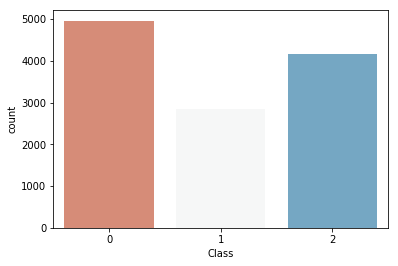

In [8]:
data = load_data()

coil = data.loc[data['Class'] == 0]
fita = data.loc[data['Class'] == 1]
helice = data.loc[data['Class'] == 2]

print(len(coil)/len(data))
print(len(fita)/len(data))
print(len(helice)/len(data))
sns.countplot(x='Class', data=data, palette='RdBu')


In [11]:
X = data.drop(['Class'], axis=1)
y = data['Class']

X = np.asarray(X)
X = position_values_to_scores(X)

print(X.shape)
X,y = sklearn.utils.shuffle([X,y])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

(11973, 9, 21, 1)
(11973, 9, 21, 1)


In [12]:
data = y_train

coil = [x for x in data if list(x) == [1,0,0]]
fita = [x for x in data if list(x) == [0,1,0]]
helice = [x for x in data if list(x) == [0,0,1]]

print(len(coil))
print(len(fita))
print(len(helice))
sns.countplot(x='Class', data=data, palette='RdBu')

3954
2276
3348


AttributeError: 'numpy.ndarray' object has no attribute 'get'

In [11]:
epochs = 10
batch_size=1024
input_shape = X.shape[1:]
#model = oldConv1DModel(input_shape,3)
model = newConv2DModel((input_shape,1),3)
#model = conv1DResnet((input_shape,1),3)


model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

predictions = model.predict(X_test, batch_size=batch_size)
value = classification_report(y_test.argmax(axis=1),
                                  predictions.argmax(axis=1))
print(value)


# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
#plt.xscale('log')
#plt.yscale('log')
plt.ylim((0,1))
plt.plot(np.arange(0,epochs), hist.history["loss"],label="train_loss")
plt.plot(np.arange(0,epochs), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,epochs), hist.history["acc"],label="train_acc")
plt.plot(np.arange(0,epochs), hist.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 9, 128)            256       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 9, 256)            33024     
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 5, 512)            655872    
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 1, 1024)           2622464   
_________________________________________________________________
average_pooling1d_4 (Average (None, 1, 1024)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1, 1024)           4096      
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
__________

AttributeError: 'NoneType' object has no attribute 'compile'

In [75]:
from keras import backend as k
k.clear_session()

In [53]:
from sklearn.ensemble import RandomForestClassifier

X = data.drop(['Class'], axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

print(confusion_matrix(y_test, clf.predict(X_test)))
print(classification_report(y_test, clf.predict(X_test)))


[[679  71 220]
 [297 153 149]
 [334  87 405]]
              precision    recall  f1-score   support

           0       0.52      0.70      0.60       970
           1       0.49      0.26      0.34       599
           2       0.52      0.49      0.51       826

    accuracy                           0.52      2395
   macro avg       0.51      0.48      0.48      2395
weighted avg       0.51      0.52      0.50      2395

